Mounted at /content/drive
1.utils_Proyecto_Deep_Learning.ipynb	     borrar
2.Proyecto_Deep_Learning_fc.ipynb	     data_main.zip
3.Proyecto_Deep_Learning_CNN.ipynb	     Enunciado_Pr├íctica_DL.pdf
4.Proyecto_Deep_Learning_ensemble.ipynb      extracted_files
5.Proyecto_Deep_Learning_Transformers.ipynb  poi_dataset.csv
Cargando CSV...
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería 

Procesando imágenes: 100%|██████████| 47/47 [13:40<00:00, 17.47s/batch]


Media: 0.445713073015213, Desviación estándar: 0.20344915986061096


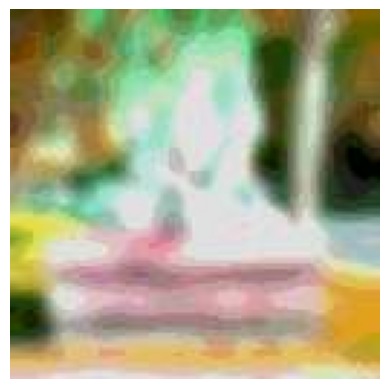

In [1]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías
import os
import zipfile
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Rutas
project_path = "/content/drive/My Drive/Colab Notebooks/Proyecto"
zip_path = os.path.join(project_path, "data_main.zip")
extract_path = os.path.join(project_path, "extracted_files")
image_folder = os.path.join(extract_path, "data_main")
csv_file_path = os.path.join(project_path, "poi_dataset.csv")
json_path = os.path.join(project_path, 'id_to_target.json')

# Ver si la carpeta del proyecto es accesible
!ls "$project_path"

# Extraer el archivo ZIP
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        print(f"Total de archivos en el ZIP: {len(file_list)}")

        for i, file in enumerate(file_list):
            zip_ref.extract(file, extract_path)
            if i % 100 == 0:
                print(f"Archivos extraídos: {i}/{len(file_list)}")

# Cargar CSV
print("Cargando CSV...")
df_csv = pd.read_csv(csv_file_path)
print(df_csv.head())

# Calcular el 'target'
df_csv['target'] = (df_csv['Likes'] + df_csv['Bookmarks'] - df_csv['Dislikes']) / (df_csv['Likes'] + df_csv['Bookmarks'] + df_csv['Dislikes'])

# diccionario id_to_target
id_to_target = dict(zip(df_csv['id'], df_csv['target']))
with open(json_path, 'w') as json_file:
    json.dump(id_to_target, json_file)


# Normalizar columnas de latitud y longitud
scaler = MinMaxScaler()
df_csv[['latitude', 'longitude']] = scaler.fit_transform(df_csv[['locationLon', 'locationLat']])

# Encoding para categorías
import ast
df_csv['categories'] = df_csv['categories'].apply(ast.literal_eval)
all_categories = [category for sublist in df_csv['categories'] for category in sublist]
unique_categories = list(set(all_categories))
category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

def one_hot_encode(categories):
    one_hot = [0] * len(unique_categories)
    for category in categories:
        one_hot[category_to_index[category]] = 1
    return one_hot

df_csv['one_hot_categories'] = df_csv['categories'].apply(one_hot_encode)

# Eliminar columnas
columns_to_drop = ['id', 'name', 'shortDescription', 'main_image_path', 'locationLon', 'locationLat', 'categories', 'tags']
df_csv = df_csv.drop(columns=columns_to_drop)

# Normalizar  columnas
columns_to_scale = ['xps', 'Visits']
df_csv[columns_to_scale] = scaler.fit_transform(df_csv[columns_to_scale])

# Dividir en conjuntos: entrenamiento, validación y prueba
X = df_csv.drop('target', axis=1)
y = df_csv['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

# Convertir a tensores
def to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

one_hot_train_tensor = torch.tensor(X_train['one_hot_categories'].tolist(), dtype=torch.float32)
numeric_train_tensor = to_tensor(X_train[['tier', 'xps', 'Visits', 'latitude', 'longitude']])
train_tensor = torch.cat((numeric_train_tensor, one_hot_train_tensor), dim=1)

# Repetir para validación y prueba
one_hot_val_tensor = torch.tensor(X_val['one_hot_categories'].tolist(), dtype=torch.float32)
numeric_val_tensor = to_tensor(X_val[['tier', 'xps', 'Visits', 'latitude', 'longitude']])
val_tensor = torch.cat((numeric_val_tensor, one_hot_val_tensor), dim=1)
one_hot_test_tensor = torch.tensor(X_test['one_hot_categories'].tolist(), dtype=torch.float32)
numeric_test_tensor = to_tensor(X_test[['tier', 'xps', 'Visits', 'latitude', 'longitude']])
test_tensor = torch.cat((numeric_test_tensor, one_hot_test_tensor), dim=1)

# Crear datasets y dataloaders
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(train_tensor, y_train_tensor)
val_data = TensorDataset(val_tensor, y_val_tensor)
test_data = TensorDataset(test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Guardar dataloaders
torch.save(train_loader, os.path.join(project_path, 'train_loader.pt'))
torch.save(val_loader, os.path.join(project_path, 'val_loader.pt'))
torch.save(test_loader, os.path.join(project_path, 'test_loader.pt'))

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

mean, std, nb_samples = 0.0, 0.0, 0
for images, _ in tqdm(dataloader, desc="Procesando imágenes", unit="batch"):
    batch_samples = images.size(0)
    images = images.view(batch_samples, -1)
    mean += images.mean(dim=1).sum(dim=0)
    std += images.std(dim=1).sum(dim=0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# transformación con normalización
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Guardar media y desviación estándar
print(f"Media: {mean.item()}, Desviación estándar: {std.item()}")

# Visualizar:
images, labels = next(iter(DataLoader(dataset, batch_size=32, shuffle=True)))
image = images[0].numpy().transpose((1, 2, 0))
image = np.clip(image, 0, 1)
plt.imshow(image)
plt.axis('off')
plt.show()
